# ARMA

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# To avoid seeing warnings
import warnings
warnings.filterwarnings('ignore')

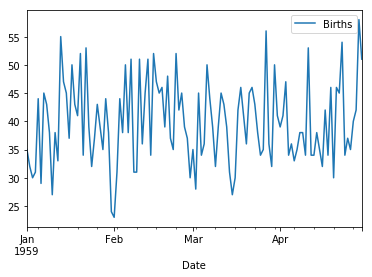

In [33]:
# Stationary 
df1 = pd.read_csv('../UPDATE_TSA_NOTEBOOKS/Data/DailyTotalFemaleBirths.csv',index_col='Date',parse_dates=True)
df1.index.freq= 'D'
df1 = df1[:120] # Cogemos los 4 primeros meses, de esta manera en mucho más estacionario para ARMA
df1.plot();

### 1. ARMA

- When we use ARMA model, we can't integrate the TS, so our TS has to be Stationary

In [15]:
from statsmodels.tsa.arima_model import ARMA, ARMAResults

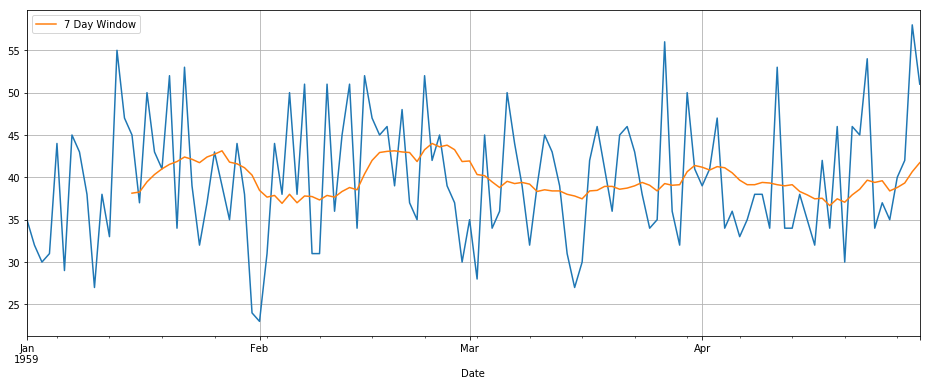

In [29]:
# It looks quite Stationary
df1['Births'].plot(figsize=(12,6),grid=True);
df1['Births'].rolling(window=15).mean().plot(figsize=(16,6),grid=True,label='7 Day Window',legend=True);

### 1.1 Augmented Dickey-Fuller Test

In [35]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [52]:
# p-value is <<<<<<< 0.05
adf_test(df1['Births'], 'Dickey-Fuller Test Births')

Augmented Dickey-Fuller Test: Dickey-Fuller Test Births
ADF test statistic     -9.855384e+00
p-value                 4.373545e-17
# lags used             0.000000e+00
# observations          1.190000e+02
critical value (1%)    -3.486535e+00
critical value (5%)    -2.886151e+00
critical value (10%)   -2.579896e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


### 1.2 ARMA orders p q

In [53]:
from pmdarima import auto_arima
auto_arima(df1['Births'],seasonal=False,trace=True).summary()

Fit ARIMA: order=(2, 0, 2); AIC=822.741, BIC=839.466, Fit time=0.868 seconds
Fit ARIMA: order=(0, 0, 0); AIC=823.489, BIC=829.064, Fit time=0.005 seconds
Fit ARIMA: order=(1, 0, 0); AIC=824.647, BIC=833.010, Fit time=0.021 seconds
Fit ARIMA: order=(0, 0, 1); AIC=824.747, BIC=833.110, Fit time=0.022 seconds
Fit ARIMA: order=(1, 0, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(3, 0, 2); AIC=830.714, BIC=850.226, Fit time=0.705 seconds
Fit ARIMA: order=(2, 0, 1); AIC=828.129, BIC=842.067, Fit time=0.133 seconds
Fit ARIMA: order=(2, 0, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 1); AIC=826.399, BIC=837.549, Fit time=0.073 seconds
Fit ARIMA: order=(3, 0, 3); AIC=nan, BIC=nan, Fit time=0.549 seconds
Total fit time: 2.428 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:                     ARMA(2, 2)   Log Likelihood                -405.370
Method:                       css-mle   S.D. of innovations              6.991
Date:                Fri, 03 May 2019   AIC                            822.741
Time:                        12:44:25   BIC                            839.466
Sample:                             0   HQIC                           829.533
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.8162      0.108    368.858      0.000      39.605      40.028
ar.L1.y        1.8569      0.081     22.938      0.000       1.698       2.016
ar.L2.y       -0.8814      0.073    -12.034      0.000      -1.025      -0.738
ma.L1.y       -1.8634      0.109    -17.128      0.000      -2.077      -1.650
ma.L2.y        0.8634      0.108      8.021      0.000       0.652       1.074
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0533           -0.1582j            1.0651           -0.0237
AR.2            1.0533           +0.1582j            1.0651            0.0237
MA.1            1.0000           +0.0000j            1.0000            0.0000
MA.2            1.1582           +0.0000j            1.1582            0.0000
-----------------------------------------------------------------------------
"""

### 1.3 Train Test Split

In [42]:
# We want to forecast one month (30 days), then our Testing Dataset has to be => 30 days
train = df1.iloc[:90]
test = df1.iloc[90:]

### 1.4 Arma Model

#### Fit

In [44]:
from statsmodels.tsa.arima_model import ARMA, ARMAResults
model = ARMA(train['Births'],order=(2,2))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                 Births   No. Observations:                   90
Model:                     ARMA(2, 2)   Log Likelihood                -307.905
Method:                       css-mle   S.D. of innovations              7.405
Date:                Fri, 03 May 2019   AIC                            627.809
Time:                        12:22:34   BIC                            642.808
Sample:                    01-01-1959   HQIC                           633.858
                         - 03-31-1959                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           39.7549      0.912     43.607      0.000      37.968      41.542
ar.L1.Births    -0.1850      1.087     -0.170      0.865      -2.315       1.945
ar.L2.Births     0.4352      0.644      0.675      0.501      -0.828       1.698
ma.L1.Births     0.2777      1.097      0.253      0.801      -1.872       2.427
ma.L2.Births    -0.3999      0.679     -0.589      0.557      -1.730       0.930
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.3181           +0.0000j            1.3181            0.5000
AR.2            1.7434           +0.0000j            1.7434            0.0000
MA.1           -1.2718           +0.0000j            1.2718            0.5000
MA.2            1.9662           +0.0000j            1.9662            0.0000
-----------------------------------------------------------------------------
"""

#### Predict

In [46]:
start = len(train)
end = len(train) + len(test) - 1
preds = results.predict(start=start,end=end).rename('ARMA (2,2) Predictions')

### 1.5 Plotting the results

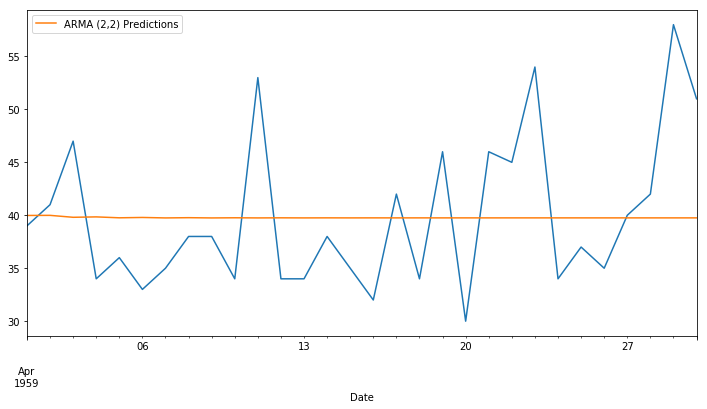

In [49]:
test['Births'].plot(figsize=(12,6))
preds.plot(legend=True);

In [50]:
test.mean()

Births    39.833333
dtype: float64

In [51]:
preds.mean()

39.7774310288188